In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nn_robust_attacks.setup_mnist import MNIST, MNISTModel

Using TensorFlow backend.


In [2]:
sess = tf.Session(config=tf.ConfigProto())
K.set_session(sess)

data = MNIST()

class MNIST_Model:
    def __init__(self, session=None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3),
                         input_shape=(28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))

        self.model = model

    def predict(self, data):
        return self.model(data)

In [3]:
num_epochs = 10
batch_size = 128
train_temp = 1

training = False

In [4]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD

def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                   logits=predicted/train_temp)

# Train first model 
modelname = "models/trained_model1"
model1 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model1.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model1.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model1.model.save(modelname)
    
else:
    model1.model = load_model(modelname, custom_objects={'fn':fn})
        
model1.model.summary()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
___________________________________________________________

In [5]:
# Train second model 
modelname = "models/trained_model2"
model2 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model2.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model2.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model2.model.save(modelname)
    
else:
    model2.model = load_model(modelname, custom_objects={'fn':fn})
    
model2.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_43 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_44 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_45 (Activation)   (None, 10, 10, 64)       

In [6]:
# Train third model 
modelname = "models/trained_model3"
model3 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model3.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model3.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model3.model.save(modelname)
    
else:
    model3.model = load_model(modelname, custom_objects={'fn':fn})
    
model3.model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_37 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_38 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_39 (Activation)   (None, 10, 10, 64)       

In [7]:
# Train fourth model 
modelname = "models/trained_model4"
model4 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model4.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model4.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model4.model.save(modelname)
    
else:
    model4.model = load_model(modelname, custom_objects={'fn':fn})
    
model4.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_43 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_44 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_45 (Activation)   (None, 10, 10, 64)       

In [8]:
from keras.datasets import mnist as data_keras
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = data_keras.load_data()
x_train = x_train[...,np.newaxis] /255.0
x_test = x_test[...,np.newaxis] / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
# Performance of first model
scores = model1.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

# Performance of second model
scores = model2.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

# Performance of third model
scores = model3.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

# Performance of fourth model
scores = model4.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

10000/10000 [==============================] - 14s 1ms/step
loss=0.060424025029380574, accuracy=0.9833999872207642
10000/10000 [==============================] - 14s 1ms/step
loss=0.060767219057303735, accuracy=0.9829999804496765
10000/10000 [==============================] - 14s 1ms/step
loss=0.1604284207782708, accuracy=0.9513999819755554
10000/10000 [==============================] - 14s 1ms/step
loss=0.06374289788251045, accuracy=0.979200005531311


In [10]:
test_size = 250
num_img = test_size // 10
trial_data = []
indicies = []

for i in range(0, 10):
    trial_data.append([])
    indicies.append([])
    for idx, img in enumerate(data.test_data):
        if np.nonzero(data.test_labels[idx])[0][0] == i:
            trial_data[i].append(data.test_data[idx])
            indicies[i].append(idx)
        if len(trial_data[i]) >= num_img:
            break

In [11]:
import random
target_data = []

for i in range(0, 10):
    target_data.append([])
    for j in range(0, int(num_img)):
        numbers = list(range(0, i)) + list(range(i + 1, 10))
        r = random.choice(numbers)
        target_data[i].append(r)

In [12]:
target_labels = []
for i in range(0, 10):
    target_labels.append(to_categorical(target_data[i]))

In [13]:
def get_label_confidence(image, model):
    pr = model.predict(image)
    print(pr)
    image_class = model.predict_classes(image)
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))

In [14]:
plt.set_cmap('Greys_r')
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
true_label = 0
inputs = np.asarray(trial_data[true_label])
targets = target_labels[true_label]

In [21]:
# Use same data for same experiment for transferability test
targets = []
targets.append(to_categorical(9))
inputs = np.load('inputs_0.csv.npy')[0:1]

In [22]:
print(targets)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)]


In [23]:
from nn_robust_attacks.l2_attack_dual import CarliniL2

adv = CarliniL2(sess, model1, model2).attack(inputs, targets)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

go up to 1
tick 0
[10000000000.0]
0 (0.021143615, 0.017088797, 0.0)
1000 (0.017262759, 0.017253831, 0.0)
2000 (0.01726816, 0.017253168, 0.0)
[10000000000.0]
0 (0.17502329, 0.17087747, 0.0)
1000 (0.17173593, 0.17073584, 0.0)
2000 (0.17174125, 0.17072748, 0.0)
[10000000000.0]
0 (1.7129292, 1.7087641, 0.0)
1000 (1.6279509, 1.5288308, 0.0)
2000 (1.6279336, 1.5287287, 0.0)
[10000000000.0]
0 (17.091793, 17.087626, 0.0)
1000 (7.7528234, 0.8351494, 0.0)
2000 (7.755621, 0.8455931, 0.029908428)
3000 (7.786645, 0.754212, 0.08010114)
[10000000000.0]
0 (170.88039, 170.87622, 0.0)
1000 (7.990629, 0.0, 0.0)
2000 (8.269975, 0.0, 0.0)
[7.7785873]
0 (93.986084, 93.98192, 0.0)
1000 (7.9434977, 0.0, 0.0)
2000 (7.9009027, 0.0, 0.0)
3000 (7.820803, 0.0, 0.0)
4000 (7.6100273, 0.0, 0.0)
5000 (7.568058, 0.0, 0.0)
6000 (7.627735, 0.0, 0.0)
[7.4976745]
0 (55.538944, 55.534775, 0.0)
1000 (7.678084, 0.049272135, 0.0)
2

In [24]:
from numpy import savetxt

np.save('1-1_inputs.csv', inputs)
np.save('1-1_adv.csv', adv)

Valid:


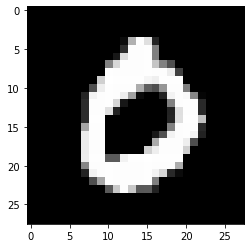

In [21]:
print("Valid:")
plt.imshow(inputs[0][:,:,0])

Adversarial:


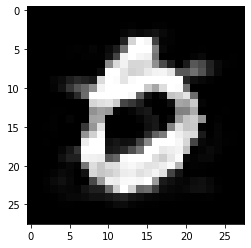

In [22]:
print("Adversarial:")
plt.imshow(adv[0][:,:,0])

Perturbation


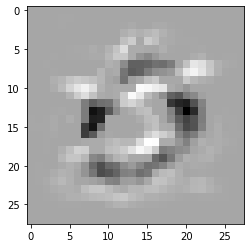

In [23]:
print('Perturbation')
plt.imshow(adv[0][:,:,0] - inputs[0][:,:,0])

In [24]:
def get_label_confidence(image, model):
    pr = model.predict(image)
    pr = np.array([np.exp(x) for x in pr])
    pr = pr / np.sum(pr)
    image_class = model.predict_classes(image)
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))

In [25]:
for i in range(0, num_img):
    print(i)
    print('Model 1', get_label_confidence(adv[i][np.newaxis, ...], model1.model))
    print('Model 2', get_label_confidence(adv[i][np.newaxis, ...], model2.model))

0

Model 1 Predicted 8 : 0.2640118
Model 2 Predicted 0 : 0.9835683
1
Model 1 Predicted 4 : 0.2831402
Model 2 Predicted 0 : 0.8878421
2
Model 1 Predicted 2 : 0.4720687
Model 2 Predicted 0 : 0.9878199
3
Model 1 Predicted 2 : 0.2582473
Model 2 Predicted 0 : 0.9975262
4
Model 1 Predicted 1 : 0.1871089
Model 2 Predicted 2 : 0.8981709
5
Model 1 Predicted 5 : 0.5000912
Model 2 Predicted 0 : 0.9917195
6
Model 1 Predicted 7 : 0.4165046
Model 2 Predicted 0 : 0.9971952
7
Model 1 Predicted 9 : 0.4967543
Model 2 Predicted 0 : 0.9999151
8
Model 1 Predicted 2 : 0.4541142
Model 2 Predicted 0 : 0.9919859
9
Model 1 Predicted 9 : 0.3498183
Model 2 Predicted 0 : 0.9972800
10
Model 1 Predicted 7 : 0.3253551
Model 2 Predicted 0 : 0.6215572
11
Model 1 Predicted 2 : 0.4695667
Model 2 Predicted 0 : 0.9903587
12
Model 1 Predicted 7 : 0.4565713
Model 2 Predicted 0 : 0.9129666
13
Model 1 Predicted 4 : 0.2507488
Model 2 Predicted 0 : 0.9995360
14
Model 1 Predicted 1 : 0.2335429
Model 2 Predicted 0 : 0.9064361
15
M

In [26]:
perturb = adv - inputs
perturb_mean =  np.sum(perturb) / num_img 
perturb_std = np.std(np.array([sum(x) for x in perturb]))
print('Mean', perturb_mean)
print('Standard Deviation', perturb_std)

Mean 2.055708312988281
Standard Deviation 0.8220224


In [27]:
# Transferability test
for i in range(0, num_img):
    print(i)
    print('Model 3', get_label_confidence(adv[i][np.newaxis, ...], model3.model))

0
Model 3 Predicted 0 : 0.9791830
1
Model 3 Predicted 0 : 0.8057699
2
Model 3 Predicted 0 : 0.7801155
3
Model 3 Predicted 0 : 0.9840521
4
Model 3 Predicted 0 : 0.7482321
5
Model 3 Predicted 0 : 0.9983676
6
Model 3 Predicted 0 : 0.9816337
7
Model 3 Predicted 0 : 0.9998204
8
Model 3 Predicted 0 : 0.9693841
9
Model 3 Predicted 0 : 0.9951007
10
Model 3 Predicted 0 : 0.8930105
11
Model 3 Predicted 0 : 0.9119163
12
Model 3 Predicted 9 : 0.4430845
13
Model 3 Predicted 0 : 0.9934924
14
Model 3 Predicted 2 : 0.9070480
15
Model 3 Predicted 0 : 0.6763878
16
Model 3 Predicted 2 : 0.8630614
17
Model 3 Predicted 2 : 0.8220745
18
Model 3 Predicted 0 : 0.9999541
19
Model 3 Predicted 0 : 0.9998093
20
Model 3 Predicted 0 : 0.9599358
21
Model 3 Predicted 2 : 0.6168079
22
Model 3 Predicted 0 : 0.9947298
23
Model 3 Predicted 0 : 0.9512933
24
Model 3 Predicted 0 : 0.9414096
